In [1]:
__author__ = 'tkurth'
import sys
import os
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from nbfinder import NotebookFinder
sys.meta_path.append(NotebookFinder())
%matplotlib inline
import time
import re
import pickle

## Load Data

In [2]:
#retrieve files
directory="/project/projectdirs/mpccc/tkurth/MANTISSA-HEP/atlas_caffe/runs"
filelist=[x for x in os.listdir(directory) if x.startswith('output')]

## Populate Arrays

In [3]:
l_data=[]
p_data=[]
for fname in filelist:
    #print "Open file "+fname
    f = h5py.File(directory+'/'+fname,'r')
    for item in f.items():
        if 'label' in item[0]:
            l_data+=list(f[item[0]].value)
        elif 'softmax' in item[0]:
            tmpvals=f[item[0]].value
            p_data+=list(tmpvals[:,1])
    f.close()

## ROC

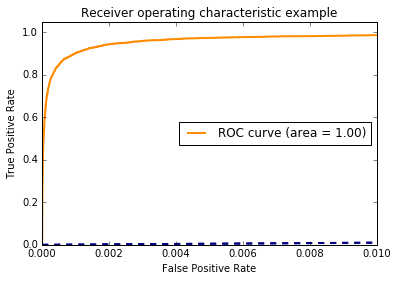

In [6]:
fpr, tpr, thresholds = metrics.roc_curve(l_data, p_data, pos_label=1)
plt.figure()
lw = 2
#full curve
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('ROC_1400_850.png',dpi=300)

#zoomed-in
#plt.plot(fpr, tpr, color='darkorange',
#         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 0.01])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="center right")
plt.savefig('ROC_1400_850_zoom.png',dpi=300)
plt.show()

In [22]:
threshold=0.99

#compute signal efficiency:
total_signal=np.sum(l_data)
found_signal=np.sum([1. if x[0]*x[1]>threshold else 0. for x in zip(l_data,p_data)])
print 'sig-efficiency: ',found_signal/total_signal
print 'sig-survivors: ',found_signal

#compute bg rejection:
total_background=np.sum([1.-x for x in l_data])
false_positive_bg=np.sum([1. if (1.-x[0])*x[1]>threshold else 0. for x in zip(l_data,p_data)])
print 'bg-rejection: ',1.-false_positive_bg/total_background
print 'bg-survivors: ',(1.-(1.-false_positive_bg/total_background))*total_background

sig-efficiency:  0.526368558251
sig-survivors:  2625.0
bg-rejection:  0.999950782048
bg-survivors:  157.0
